In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT

%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NOISE_SCALE = 20
NUM_ACTIVATIONS = 3
K = 5
VIS_CORRECT = False

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE,
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [5]:
# Custom loss to maximize activation
def activation_loss(mod, inp, targ):
    _, rep = mod(inp, with_latent=True, fake_relu=True)
    loss = rep[:,targ]
    return loss, None

In [6]:
# PGD Parameters
kwargs = {
    #'criterion': ch.nn.CrossEntropyLoss(),
    'custom_loss': activation_loss,
    'constraint':'2',
    'eps': 500,
    'step_size': .5,
    'iterations': 1500,
    'do_tqdm': True,
    'targeted': False,
}

In [7]:
# Obtain representations for all images in the test set
img_test, rep_test = [], []
n = 0

it = tqdm(enumerate(test_loader))
for i, (im, targ) in it:
    n += im.shape[0]
    it.set_description(f"Completed: {i}/{len(test_loader)}")
    with ch.no_grad():
        (_, rep), _ = model(im, with_latent=True)
        rep_test.append(rep.cpu().numpy())
    img_test.append(im)

rep_test = np.concatenate(rep_test)
img_test = ch.cat(img_test)

Completed: 1014/1015: : 1015it [00:25, 40.26it/s]


In [8]:
# Find images that maximally/minimally activate a specific activation
    
def get_topk_imgs(index, dist=lambda x:x):
    top_k = dist(rep_test[:,index]).argsort()[-K:][::-1]
    res = ch.cat([img_test[i:i+1] for i in top_k])
    return res.cpu()

def get_relevant_imgs(actvn):
    img_seed = 0.5 * ch.ones(1,3,224,224) # Random seed image
    # Visualize feature corresponding to maximizing specific activation
    _ , img_feat = model(inp=img_seed, target=actvn, make_adv=True, fake_relu=True, **kwargs)
    # Find images that activate given activation the most
    img_max = get_topk_imgs(actvn)
    # Find images that activate given activation the least
    img_min = get_topk_imgs(actvn, dist=lambda x:-x)
    return img_seed.cpu(), img_feat.cpu(), img_max.cpu(), img_min.cpu()

Widget Javascript not detected.  It may not be installed or enabled properly.


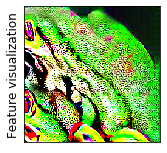

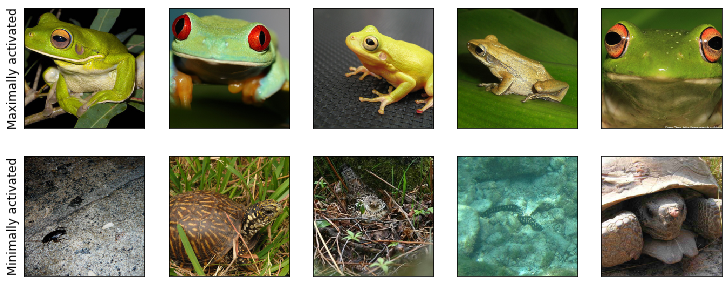

In [9]:
TARGET = 256

_, feature, max_act, min_act = get_relevant_imgs(TARGET)

show_image_row([feature], ['Feature visualization'])
show_image_row([max_act, min_act], ['Maximally activated', 'Minimally activated'])